In [1]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
tf.__version__

'2.11.0'

# 7.9 Hands-On Back Propagation Algorithm

## 7.9.1 Dataset

In [2]:
N_SAMPLES = 2000
TEST_SIZE = 0.3
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
print(X.shape, y.shape)

(2000, 2) (2000,)


In [3]:
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$x_1$", ylabel="$x_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='none')
    plt.savefig('dataset.svg')
    plt.close()

make_plot(X, y, "Classification Dataset Visualization ")
plt.show()

## 7.9.2 Network Layer

In [4]:
class Layer:
    def __init__(self, n_input, n_neurons, activation=None, weights=None, bias=None):
        self.weights = weights if weights is not None else np.random.randn(n_input, n_neurons) * np.sqrt(1 / n_neurons)
        self.bias = bias if bias is not None else np.random.rand(n_neurons) * 0.1
        self.activation = activation
        self.last_activation = None
        self.error = None
        self.delta = None
    def activate(self, x):
        r = np.dot(x, self.weights) + self.bias
        self.last_activation = self._apply_activation(r)
        return self.last_activation
    def _apply_activation(self, r):
        if self.activation is None:
            return r
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        elif self.activation == 'tanh':
            return np.tanh(r)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        return r
    def apply_activation_derivative(self, r):
        if self.activation is None:
            return np.ones_like(r)
        elif self.activation == 'relu':
            grad = np.array(r, copy=True)
            grad[r > 0] = 1.
            grad[r <= 0] = 0.
            return grad
        elif self.activation == 'tanh':
            return 1 - r ** 2
        elif self.activation == 'sigmoid':
            return r * (1 - r)
        return r

## 7.9.3 Neural Network

In [5]:
class NeuralNetwork:
    def __init__(self):
        self._layers = []
        self.W=[]
    def add_layer(self, layer):
        self._layers.append(layer)
    def feed_forward(self, X):
        for layer in self._layers:
            X = layer.activate(X)
        return X
    def backpropagation(self, X, y, learning_rate):
        output = self.feed_forward(X)
        for i in reversed(range(len(self._layers))): 
            layer = self._layers[i]
            if layer == self._layers[-1]:
                layer.error = y - output
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else:
                next_layer = self._layers[i + 1]
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error * layer.apply_activation_derivative(layer.last_activation)
                for i in range(len(self._layers)):
                    layer = self._layers[i]
                    o_i = np.atleast_2d(X if i == 0 else self._layers[i - 1].last_activation)
                    layer.weights += layer.delta * o_i.T * learning_rate
        return output
    def predict(self, X, addBias=True):
        p = np.atleast_2d(X)
        if addBias:
            p = np.c_[p, np.ones((p.shape[0]))]
        for layer in np.arange(0, len(self.W)):
            p = self.sigmoid(np.dot(p, self.W[layer]))
        return p
    def train(self, X_train, X_test, y_train, y_test, learning_rate, max_epochs):
        y_onehot = np.zeros((y_train.shape[0], 2))
        y_onehot[np.arange(y_train.shape[0]), y_train] = 1
        mses = []
        for i in range(max_epochs):
            for j in range(len(X_train)):
                self.backpropagation(X_train[j], y_onehot[j], learning_rate)
                if i % 10 == 0:
                    mse = np.mean(np.square(y_onehot - self.feed_forward(X_train)))
                    mses.append(mse)
                    print('Epoch: #%s, MSE: %f' % (i, float(mse)))
                    print('Accuracy: %.2f%%' % (self.accuracy(self.predict(X_test), y_test.flatten()) * 100))
        return mses

## 7.9.4 Network Training

## 7.9.5 Network Performance

In [6]:
input_size = 2
hidden_size = 25
output_size = 2
learning_rate = 0.1
max_epochs = 1000

nn = NeuralNetwork()
layer1 = Layer(n_input=input_size, n_neurons=hidden_size, activation='sigmoid', 
               weights=np.random.randn(input_size, hidden_size), bias=np.random.rand(hidden_size) * 0.1)
layer2 = Layer(n_input=input_size, n_neurons=hidden_size, activation='sigmoid', 
               weights=np.random.randn(input_size, hidden_size), bias=np.random.rand(hidden_size) * 0.1)
layer3 = Layer(n_input=input_size, n_neurons=hidden_size, activation='sigmoid', 
               weights=np.random.randn(input_size, hidden_size), bias=np.random.rand(hidden_size) * 0.1)

nn.add_layer(layer1)
nn.add_layer(layer2)
nn.add_layer(layer3)


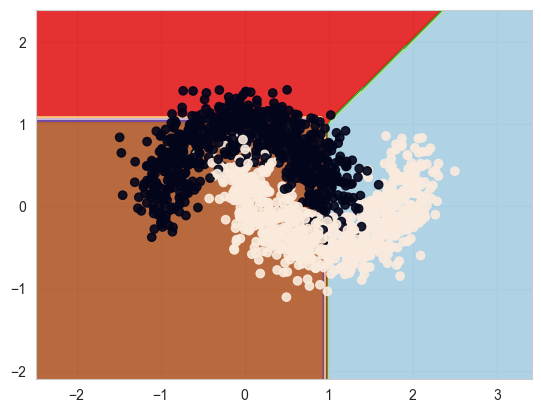

In [11]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.9)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.9)
plt.show()
